In this notebook, we are constructing a machine learning model to forecast real estate prices in Belgium. We will proceed through these steps:

- Step 1: Data cleaning and preprocessing
- Step 2: Model selection and training
- Step 3: Model evaluation
Depending on the evaluation results of the model, we may repeat steps 1-3 as necessary.

# Step 1: Data cleaning and preprocessing

We begin by importing the python packages and modules we will be using. Next we'll import our csv file as a dataframe and have a look how our dataframe looks like. 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


#Import dataset and have a look on the first entries
df = pd.read_csv("data_set_immoweb.csv")
df.head()



,Unnamed: 0.1,Locality,Type_of_property,Subtype_of_property,Price,Type_of_sale,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades,Swimming_pool,State_of_the_building,Unnamed: 0
0,0,1130,APARTMENT,PENTHOUSE,450000.0,residential_sale,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN,0.0
1,1,1140,APARTMENT,PENTHOUSE,450000.0,residential_sale,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN,1.0
2,2,1140,APARTMENT,PENTHOUSE,450000.0,residential_sale,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN,2.0
3,3,1180,APARTMENT,APARTMENT,485000.0,residential_sale,2.0,107.0,USA_HYPER_EQUIPPED,False,False,True,17.0,NaN,NaN,NaN,NaN,False,AS_NEW,3.0
4,4,1000,APARTMENT,DUPLEX,460000.0,residential_sale,3.0,147.0,USA_HYPER_EQUIPPED,False,False,True,52.0,NaN,NaN,NaN,2.0,NaN,NaN,4.0


In [34]:
# Cleaning the dataset

#(1) Drop indices as Pandas creates indices too
df.drop('Unnamed: 0.1', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

#(2) Remove duplicates 
df.drop_duplicates(inplace=True)

#(3) No blank spaces. This method will delete the rows with ALL Nan values
df.dropna(how='all') 

#(4) Change the name of locality to Postal_code:
df.rename(columns={'Locality' :'Postal_code'},inplace=True)

#(5) Drop other columns which we won't use: 
remove_columns=['Swimming_pool','Number_of_facades', 'Terrace', 'Garden', 'Open_fire','Furnished']
df.drop(remove_columns, axis=1, inplace=True)





Our goal is to have the model predict prices for houses and apartments. We will continue to only use data for apartments and houses (Type of property) and only consider residential sales (type of sale) as we previously did. This is to exclude non-sale properties which were included in other types of sales.

In [35]:
#Dataset with only apartments and houses
df=df[df.Type_of_property.isin(['APARTMENT','HOUSE'])]

#Dataset with only residential sales
df=df[df.Type_of_sale=='residential_sale']

#Remove the Type_of_sale as it has only 1 value:
df=df.drop('Type_of_sale', axis=1)


Our objective is to predict prices, so we will only consider the data that contains price listings and remove any rows that do not have a price specified.

In [36]:
#Removing outliers
df=df[(df.Price>100000) & (df.Price<2000000)]

#Removing rows with missing values for Price
df.dropna(subset=['Price'], inplace=True)

#Changing type of Price
df['Price']=df['Price'].astype(int)


In order to further analyse or dataset, we'll write a function that gives more information about each column. 

In [37]:
def analyze(dataframe):
    """
    This function shows all the columns of the dataframe.
    It prints the number of the unique values and also prints the unique values if it's less than 25. 
    Furthermore it shows you the number of missing values for each column and the column type. 
    """
    for i in dataframe.columns: 
        print(f"**************{i}**************") 
        if dataframe[i].nunique() <25:
            print(dataframe[i].unique())
        print("Number of unique values:",dataframe[i].nunique())
        print("Missing values:",dataframe[i].isnull().sum())
        print("Type:",dataframe[i].dtype)

In [38]:
#Use function 'analyze()' to get information about each column in the dataframe
analyze(df)

**************Postal_code**************
Number of unique values: 903
Missing values: 0
Type: int64
**************Type_of_property**************
['APARTMENT' 'HOUSE']
Number of unique values: 2
Missing values: 0
Type: object
**************Subtype_of_property**************
['PENTHOUSE' 'APARTMENT' 'DUPLEX' 'GROUND_FLOOR' 'FLAT_STUDIO' 'LOFT'
 'TRIPLEX' 'SERVICE_FLAT' 'KOT' 'HOUSE' 'APARTMENT_BLOCK' 'VILLA'
 'MANSION' 'MIXED_USE_BUILDING' 'EXCEPTIONAL_PROPERTY' 'COUNTRY_COTTAGE'
 'BUNGALOW' 'TOWN_HOUSE' 'FARMHOUSE' 'CHALET' 'CASTLE' 'OTHER_PROPERTY'
 'MANOR_HOUSE']
Number of unique values: 23
Missing values: 0
Type: object
**************Price**************
Number of unique values: 1515
Missing values: 0
Type: int32
**************Number_of_rooms**************
[ 3.  2.  1.  0.  4.  6.  5. 12.  7.  8.  9. 10. 16. 14. 17. 25. 11. 13.
 15. 19.]
Number of unique values: 20
Missing values: 0
Type: float64
**************Living_Area**************
Number of unique values: 606
Missing values: 787
Ty

We had intended to remove any columns with only one unique value, however, there were none in this dataset. After further examination, we discovered that there are still missing values that must be addressed. Additionally, we need to convert the categorical data into numerical values.

In [39]:
#Using dictionnaries to map string values to numbers
df = df.replace({"Type_of_property":{"APARTMENT": 1, "HOUSE": 2}})
df = df.replace({"Subtype_of_property":{"PENTHOUSE": 1,"APARTMENT": 2, "DUPLEX": 3, "GROUND_FLOOR": 4, "FLAT_STUDIO": 5,"LOFT": 6, "TRIPLEX": 7, "SERVICE_FLAT": 8, "APARTMENT_GROUP": 9, "KOT": 10, "HOUSE": 11, "HOUSE_GROUP": 12, "APARTMENT_BLOCK": 13, "VILLA": 14, "MANSION": 15, "MIXED_USE_BUILDING": 16, "EXCEPTIONAL_PROPERTY": 17, "COUNTRY_COTTAGE": 18, "BUNGALOW": 19, "TOWN_HOUSE": 20, "FARMHOUSE": 21, "CHALET": 22, "CASTLE": 23, "OTHER_PROPERTY": 24, "MANOR_HOUSE": 25}})
df = df.replace({"Fully_equipped_kitchen":{"NOT_INSTALLED": 0, "USA_HYPER_EQUIPPED": 1, "INSTALLED": 2, "HYPER_EQUIPPED": 3, "SEMI_EQUIPPED": 4, "USA_INSTALLED": 5, "USA_SEMI_EQUIPPED": 6, "USA_UNINSTALLED": 7}})
df = df.replace({"State_of_the_building":{"AS_NEW": 1, "JUST_RENOVATED": 2, "TO_RESTORE": 3, "GOOD": 4, "TO_RENOVATE": 5, "TO_BE_DONE_UP": 6}})

In this step we'll deal with missing values.

In [40]:
#List of missing values in any column
missing_columns = df.columns[df.isna().any()].tolist()

print(missing_columns)

['Living_Area', 'Fully_equipped_kitchen', 'Terrace_Area', 'Garden_Area', 'Surface_area_of_the_plot_of_land', 'State_of_the_building']


We start with Living_Area. As there's a little correlation between Living_Area and Number_of_rooms we can use the latter to predict the Living_Area. 

In [41]:
#Removing missing values for Living_Area depending on number_of_rooms

# Consider only properties with less than 11 rooms. 
df['Number_of_rooms']= df['Number_of_rooms'].astype(int)
df=df[df.Number_of_rooms<11]

#Change missing value in Living_Area by corresponding mean area depending to the type of property and number_of_rooms.
df['Living_Area'] = df['Living_Area'].fillna(df.groupby(['Type_of_property','Number_of_rooms'])['Living_Area'].transform('mean'))
df['Living_Area']=df['Living_Area'].astype(int)

In [42]:
#Removing missing values for Fully_equipped_kitchen depending 

df['Fully_equipped_kitchen'].fillna(0, inplace=True)
df['Fully_equipped_kitchen'] = df['Fully_equipped_kitchen'].apply(lambda x : "False" if x in [0,7] else "True")
df = df.replace({"Fully_equipped_kitchen": {"False": 0, "True": 1}})
df['Fully_equipped_kitchen']= df['Fully_equipped_kitchen'].astype(int)


In [43]:
#Removing missing values for Terrace_Area
df['Terrace_Area'].fillna(0, inplace=True)
df['Terrace_Area']=df['Terrace_Area'].astype(int)

#Removing missing values for Surface_area_of_the_plot_of_land
df['Surface_area_of_the_plot_of_land'].fillna(0, inplace=True)
df['Surface_area_of_the_plot_of_land']=df['Surface_area_of_the_plot_of_land'].astype(int)

#Removing missing values for Garden_Area
df['Garden_Area'].fillna(0, inplace=True)
df['Garden_Area']=df['Garden_Area'].astype(int)

#Removing missing values for State_of_the_building
df['State_of_the_building'].fillna("GOOD", inplace=True)
df = df.replace({"State_of_the_building":{"AS_NEW": 1, "JUST_RENOVATED": 2, "TO_RESTORE": 3, "GOOD": 4, "TO_RENOVATE": 5, "TO_BE_DONE_UP": 6}})
df['State_of_the_building']=df['State_of_the_building'].astype(int)

As a last process in this step, we will add a column with 10 provinces of Belgium and the region Brussels. We want to see the effect of this feature in our ML model. 

In [44]:
#Function to convert postal code to the 10 provinces or Brussels 
def provinces(postal_code):
    """
    This function converts the postal_code into the provinces of Belgium. It includes also the region Brussels. 
    """
    if 1000 <= postal_code < 1300:
        return "Brussels"
    elif 1300 <= postal_code < 1500:
        return "Walloon Brabant"
    elif (postal_code >= 1500 and postal_code < 2000) or (postal_code >= 3000 and postal_code < 3500):
        return "Flemish Brabant"
    elif 2000 <= postal_code < 3000:
        return "Antwerp"
    elif 3500 <= postal_code < 4000:
        return "Limburg"
    elif 4000 <= postal_code < 5000:
        return "Liège"
    elif 5000 <= postal_code < 6000:
        return "Namur"
    elif (postal_code >= 6000 and postal_code < 6600) or (postal_code >= 7000 and postal_code < 8000):
        return "Hainaut" 
    elif 6600 <= postal_code < 7000:
        return "Luxembourg"
    elif 8000 <= postal_code < 9000:
        return "West Flanders"  
    else: 
        return "East Flanders"

#add column next to postalcode
df.insert(1, 'Province', df.Postal_code.apply(provinces))

In [45]:
analyze(df)

**************Postal_code**************
Number of unique values: 901
Missing values: 0
Type: int64
**************Province**************
['Brussels' 'Walloon Brabant' 'West Flanders' 'East Flanders' 'Liège'
 'Hainaut' 'Luxembourg' 'Flemish Brabant' 'Namur' 'Antwerp' 'Limburg']
Number of unique values: 11
Missing values: 0
Type: object
**************Type_of_property**************
[1 2]
Number of unique values: 2
Missing values: 0
Type: int64
**************Subtype_of_property**************
[ 1  2  3  4  5  6  7  8 10 11 13 14 15 16 17 18 19 20 21 22 24 25 23]
Number of unique values: 23
Missing values: 0
Type: int64
**************Price**************
Number of unique values: 1513
Missing values: 0
Type: int32
**************Number_of_rooms**************
[ 3  2  1  0  4  6  5  7  8  9 10]
Number of unique values: 11
Missing values: 0
Type: int32
**************Living_Area**************
Number of unique values: 596
Missing values: 0
Type: int32
**************Fully_equipped_kitchen*************

We have no missing values and the dataset seems clean. We'll save everything in a file so that we have a cleaned version of the dataset. 

In [46]:
df.to_csv("cleaned_data_set_immoweb.csv")

# Step 2: Data formatting and model selection

We can run the following code to work directly with our cleaned dataset. 

In [42]:
"""
df = pd.read_csv("cleaned_data_set_immoweb.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()
"""

''

After conducting correlation tests in a previous project, we will be narrowing down our features. Although we wish to keep as many columns as possible, some columns have a strong relation, such as Province and Postal code and Type_of_property and Subtype_of_property, so we will only retain one of each pair.

In [78]:
df=df.drop(['Province','Fully_equipped_kitchen','Type_of_property'], axis=1)

#Selecting our features
X=df.drop(['Price'], axis=1)

#Target
y=df['Price']

In [ ]:
# dividing dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

#Select model
from sklearn.ensemble import RandomForestRegressor
    
# Train the model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=200) 
rf_model.fit(X_train,y_train)

# Step 3: Model evaluation

To achieve a high level of accuracy and effectively compare it, we have created a function to measure the metrics.

In [80]:
def performance(model): 
    """ 
    Works only with following formatted dataset: X_train, X_test, y_train, y_test
    This function tests the performance of the model. It will give an idea about the following metrics: 
    -- Mean Absolute Error (MAE): This is a measure of the average difference between the predicted values and the true values. 
    -- R²: This is a measure of how well the model fits the data, with a value between 0 and 
    """
    mae= mean_absolute_error(y_test,model.predict(X_test))
    r2 = r2_score(y_test, rf_model.predict(X_test))
    print(f"This model has a Mean Absolute error of {round(mae)}. The accuracy is {round(r2*100)}%")


In [81]:
performance(rf_model)

This model has a Mean Absolute error of 90211. The accuracy is 75%


We also evaluated the model using various plots, one of them is the plot showing the importance of each feature which was helpful in selecting the features.

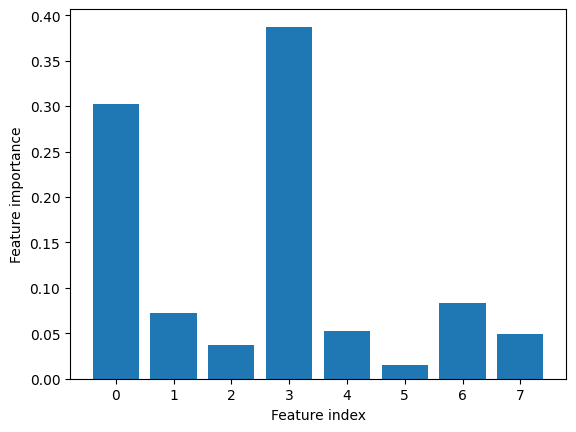

In [82]:
# feature importance
importance = rf_model.feature_importances_

# plot feature importance
plt.bar(range(X.shape[1]), importance)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()

The following plot shows the difference between the predicted values and the actual values. The residuals should be randomly distributed around zero (for a good model). We see that this is the case for a price range between 250,000 EUR and 750,000 EUR. 

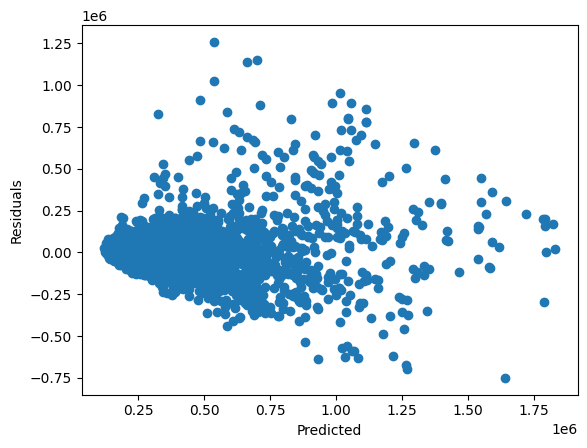

In [83]:
# predict the target variable using the model
y_pred = rf_model.predict(X_test)

# calculate the residuals
residuals = y_test - y_pred

# create a scatter plot of the residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

Next we'll make a scatterplot of the predicted values and compare it with the real values. 

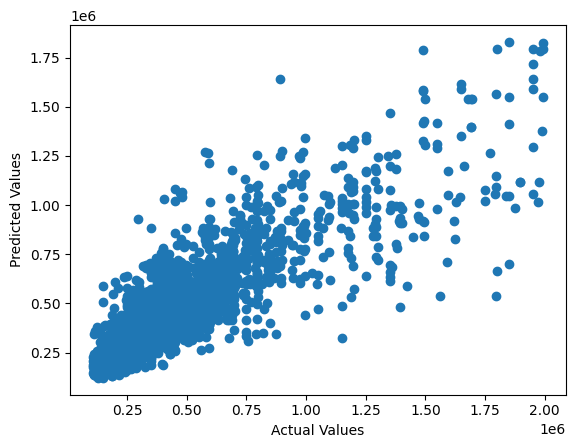

In [84]:
# predict the target variable using the model
y_pred = rf_model.predict(X_test)

# create a scatter plot of the predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


We can again see that the model is performing well for a price range between 250,000 EUR and 750,000 EUR. The points on the plot form a diagonal line indicating that the predicted values are similar to the actual values.